In [26]:
import pandas as pd
import numpy as np
import calendar

def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)
from ydata_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Sell Prices

In [27]:
sell_prices = pd.read_csv("../../Data/sell_prices.csv")
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [28]:
ProfileReport(sell_prices, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:22<00:00,  5.54s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
sell_prices_calendar = pd.read_csv('../../Data/calendar.csv')

sell_prices = (
    sell_prices
    .merge(sell_prices_calendar[['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd']], on='wm_yr_wk', how='left')
)

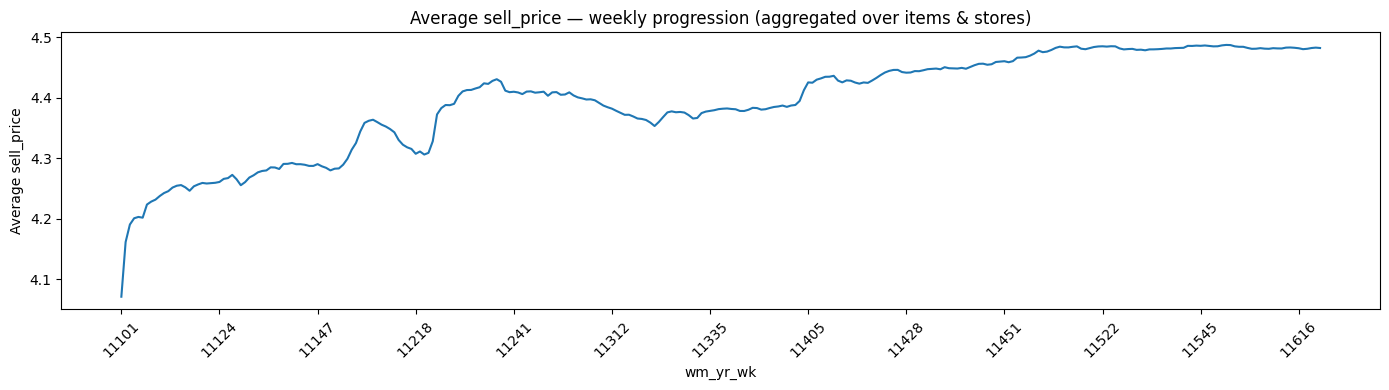

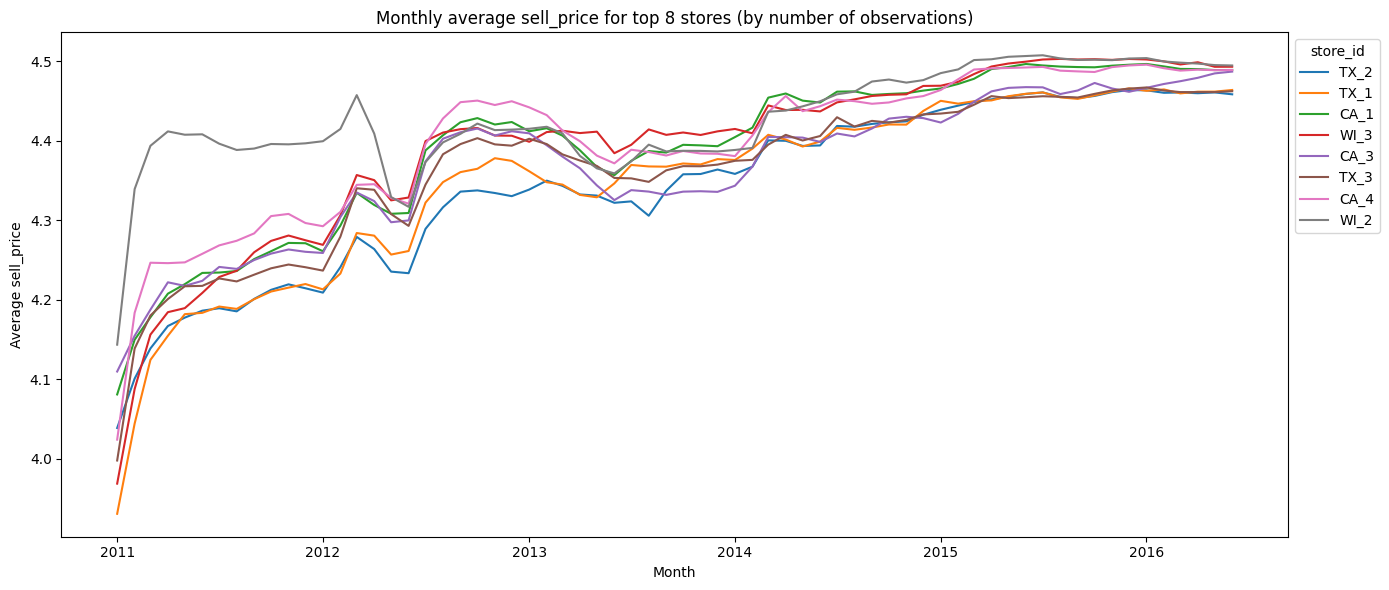

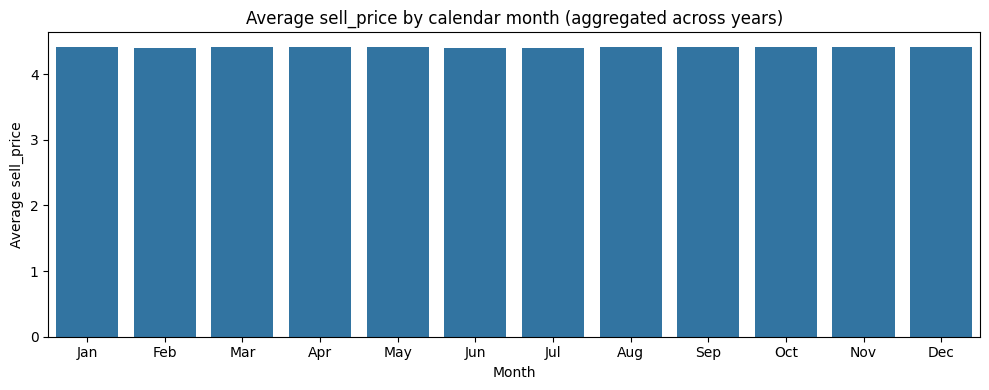

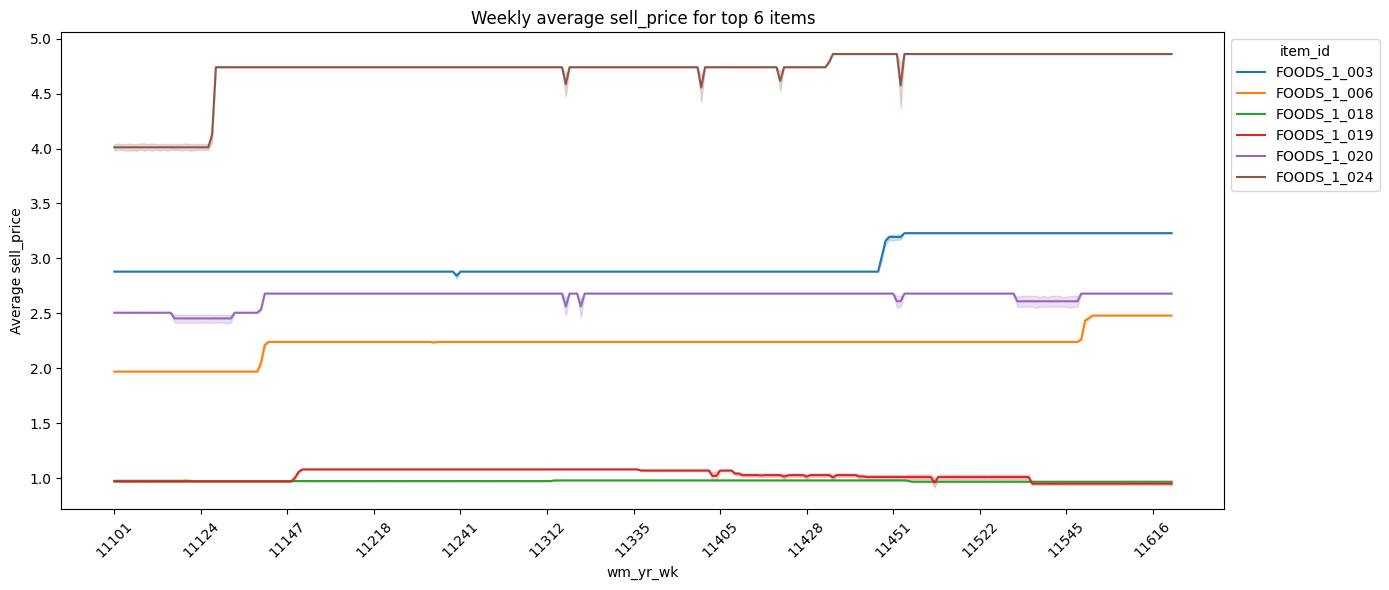

In [30]:
# Convert wm_yr_wk to string (safe categorical) and create an ordered week index
sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(str)
week_order = sorted(sell_prices['wm_yr_wk'].unique(), key=lambda x: int(x))
week_order_map = {wk: i for i, wk in enumerate(week_order)}
sell_prices['week_idx'] = sell_prices['wm_yr_wk'].map(week_order_map)

# Create a month_start timestamp for monthly aggregations (first day of month)
sell_prices['month_start'] = pd.to_datetime(dict(year=sell_prices['year'], month=sell_prices['month'], day=1))

# ---------- PLOT 1: overall price progression aggregated by week (wm_yr_wk) ----------
weekly_price = sell_prices.groupby('week_idx', as_index=False)['sell_price'].mean().sort_values('week_idx')

plt.figure(figsize=(14,4))
sns.lineplot(x=weekly_price['week_idx'], y=weekly_price['sell_price'])
# make x-axis labels readable: show actual wm_yr_wk labels every N ticks
N = max(1, len(weekly_price)//12)  # show ~12 labels max
xticks = np.arange(0, len(weekly_price), N)
plt.xticks(xticks, [week_order[i] for i in xticks], rotation=45)
plt.xlabel('wm_yr_wk')
plt.ylabel('Average sell_price')
plt.title('Average sell_price — weekly progression (aggregated over items & stores)')
plt.tight_layout()
plt.show()


# ---------- PLOT 2: progression aggregated by store_id, month (monthly average per store) ----------
store_month = sell_prices.groupby(['store_id','month_start'])['sell_price'].mean().reset_index()
pivot_sm = store_month.pivot(index='month_start', columns='store_id', values='sell_price')

# Plot only top N stores by overall average price stability or by count to keep plot readable
TOP_N = 8
top_stores = (sell_prices.groupby('store_id')['sell_price']
              .count()
              .nlargest(TOP_N)
              .index
              .tolist())

plt.figure(figsize=(14,6))
for s in top_stores:
    if s in pivot_sm.columns:
        sns.lineplot(x=pivot_sm.index, y=pivot_sm[s], label=s)
plt.legend(title='store_id', loc='upper left', bbox_to_anchor=(1,1))
plt.title(f'Monthly average sell_price for top {TOP_N} stores (by number of observations)')
plt.xlabel('Month')
plt.ylabel('Average sell_price')
plt.tight_layout()
plt.show()


# ---------- PLOT 3: seasonality — average price by calendar month (Jan..Dec aggregated across years) ----------
monthly_of_year = sell_prices.groupby('month')['sell_price'].mean().reindex(range(1,13)).fillna(0)

plt.figure(figsize=(10,4))
sns.barplot(x=list(range(1,13)), y=monthly_of_year.values)
plt.xticks(ticks=range(12), labels=[calendar.month_abbr[i] for i in range(1,13)])
plt.title('Average sell_price by calendar month (aggregated across years)')
plt.xlabel('Month')
plt.ylabel('Average sell_price')
plt.tight_layout()
plt.show()


# ---------- PLOT 4: optional — weekly price progression per item or per store (faceted) ----------
# If you want to inspect price evolution for a hansales_valul of items:
TOP_ITEMS = 6
top_items = (sell_prices.groupby('item_id')['sell_price'].count()
             .nlargest(TOP_ITEMS)
             .index
             .tolist())
sales_val_top_items = sell_prices[sell_prices['item_id'].isin(top_items)]

plt.figure(figsize=(14,6))
sns.lineplot(data=sales_val_top_items, x='week_idx', y='sell_price', hue='item_id', estimator='mean')
# x ticks as before
xticks = np.arange(0, sales_val_top_items['week_idx'].max()+1, max(1,(sales_val_top_items['week_idx'].max()+1)//12))
plt.xticks(xticks, [week_order[i] for i in xticks], rotation=45)
plt.title(f'Weekly average sell_price for top {TOP_ITEMS} items')
plt.xlabel('wm_yr_wk')
plt.ylabel('Average sell_price')
plt.legend(title='item_id', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.show()

- Sell Prices dataset starts on 2013 not 2011

- There is an upward trend (prices get higher, probably in line with inflation)

- Items are discounted in some weeks 

Ideas:

- define promotions: reductions in price for a short period of time (maybe up to 2-3 weeks)

- create delta price, maybe relative to original price

- check cointegration between price and sales (maybe correlation first)

In [31]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,weekday,wday,month,year,d,week_idx,month_start
0,CA_1,HOBBIES_1_001,11325,9.58,Saturday,1,7,2013,d_897,128,2013-07-01
1,CA_1,HOBBIES_1_001,11325,9.58,Sunday,2,7,2013,d_898,128,2013-07-01
2,CA_1,HOBBIES_1_001,11325,9.58,Monday,3,7,2013,d_899,128,2013-07-01
3,CA_1,HOBBIES_1_001,11325,9.58,Tuesday,4,7,2013,d_900,128,2013-07-01
4,CA_1,HOBBIES_1_001,11325,9.58,Wednesday,5,7,2013,d_901,128,2013-07-01


**This is a good exercise to do**

In [32]:
# --- 0. ensure we have a sortable day order ---
# The sample has a 'd' like 'd_897' — extract numeric suffix to order rows reliably.
# If you already have a true date column, replace this with pd.to_datetime(date_col) and sort by it.
sell_prices['day_num'] = sell_prices['d'].str.extract(r'(\d+)$').astype(int)
sell_prices = sell_prices.sort_values(['store_id', 'item_id', 'day_num']).reset_index(drop=True)

# --- 1. baseline price: rolling median over a long window (e.g., 90 rows ~ ~3 months if daily) ---
# Use a larger window than expected promo length so short promo windows won't change baseline much.
ROLL_WINDOW = 90
sell_prices['baseline'] = (
    sell_prices
    .groupby(['store_id', 'item_id'])['sell_price']
    .transform(lambda s: s.rolling(window=ROLL_WINDOW, min_periods=1).median())
)

In [33]:
# --- 2. detect promo days (price strictly below baseline by a tolerance) ---
EPS = 1e-6
sell_prices['is_promo'] = sell_prices['sell_price'] < (sell_prices['baseline'] - EPS)

# --- 3. assign a segment id for consecutive-runs of is_promo / non-promo per store/item ---
# This makes unique ids for runs of equal is_promo value.
sell_prices['run_id'] = (
    sell_prices
    .groupby(['store_id', 'item_id'])['is_promo']
    .apply(lambda x: (x != x.shift(1)).cumsum())
    .reset_index(level=[0,1], drop=True)
)

<Axes: xlabel='day_num', ylabel='run_id'>

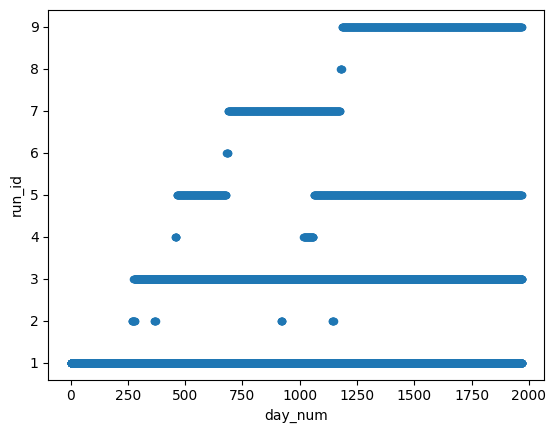

In [34]:
sell_prices.loc[lambda x: x['item_id'] == 'FOODS_1_001', :].sort_values('day_num').plot.scatter(x='day_num', y='run_id')

In [35]:
# --- 4. For runs that are promo (is_promo==True) compute a constant absolute and relative reduction ---
# We'll define promo_price_for_segment as the minimum sell_price in the segment (typical for a fixed promo price).
seg_idx = ['store_id', 'item_id', 'run_id']

# segment-level promo price (min in the run)
sell_prices['seg_min_price'] = (
    sell_prices[sell_prices['is_promo']]
    .groupby(seg_idx)['sell_price']
    .transform('min')
)
# segment-level baseline (use median or first baseline in the run)
sell_prices['seg_baseline'] = (
    sell_prices[sell_prices['is_promo']]
    .groupby(seg_idx)['baseline']
    .transform('median')
)

# Fill these values back into all rows (non-promo rows will be NaN and handled below)
sell_prices['seg_min_price'] = sell_prices.groupby(seg_idx)['seg_min_price'].transform('first')
sell_prices['seg_baseline'] = sell_prices.groupby(seg_idx)['seg_baseline'].transform('first')

# absolute and relative promo values (constant per segment)
sell_prices['promo_abs_const'] = np.where(
    sell_prices['is_promo'],
    sell_prices['seg_baseline'] - sell_prices['seg_min_price'],
    0.0
)
sell_prices['promo_rel_const'] = np.where(
    sell_prices['is_promo'],
    sell_prices['promo_abs_const'] / sell_prices['seg_baseline'],
    0.0
)

# Replace tiny negatives due to numeric issues with 0
sell_prices['promo_abs_const'] = sell_prices['promo_abs_const'].clip(lower=0.0)
sell_prices['promo_rel_const'] = sell_prices['promo_rel_const'].clip(lower=0.0)

# drop helper cols if you don't want them
sell_prices = sell_prices.drop(columns=['run_id', 'seg_min_price', 'seg_baseline'])


<Axes: xlabel='day_num', ylabel='sell_price'>

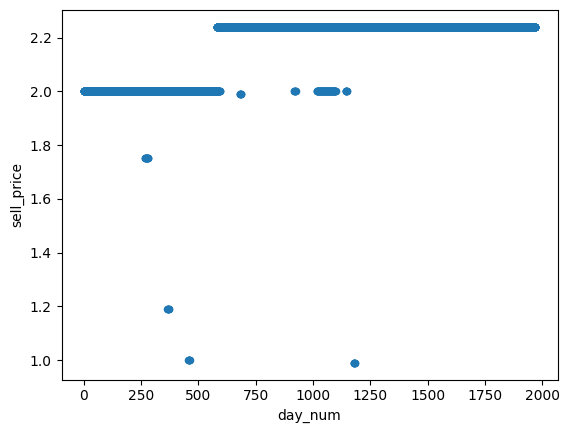

In [39]:
sell_prices.loc[lambda x: x['item_id'] == 'FOODS_1_001', :].sort_values('day_num').plot.scatter(x='day_num', y='sell_price')

<Axes: xlabel='day_num', ylabel='promo_rel_const'>

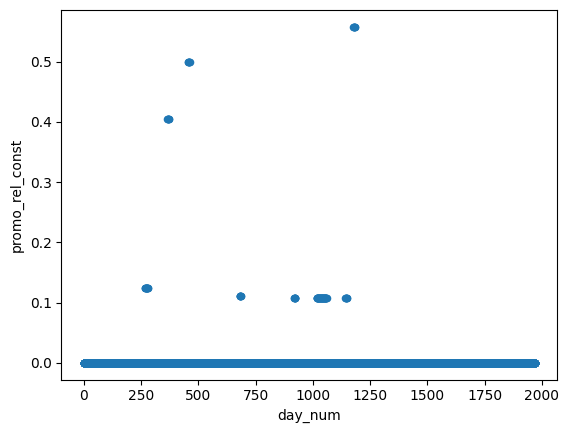

In [40]:
sell_prices.loc[lambda x: x['item_id'] == 'FOODS_1_001', :].sort_values('day_num').plot.scatter(x='day_num', y='promo_rel_const')